In [1]:
# Install and import
!pip install --quiet --upgrade pip
!pip install --quiet "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.4 MB/s eta 0:00:00


In [2]:
import time
import csv
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

Define how many GPUs to use (None for all available)

In [3]:
num_devices = None  # e.g., 2 to use first two GPUs, or None to auto-detect all

Discover and select devices

In [4]:
all_devices = jax.local_devices()
total_devices = len(all_devices)
if num_devices is None or num_devices > total_devices:
    n_devices = total_devices
else:
    n_devices = num_devices

selected_devices = all_devices[:n_devices]
print(f"Using {n_devices}/{total_devices} GPUs: {selected_devices}")

Using 1/1 GPUs: [CudaDevice(id=0)]


Dtype setup

In [5]:
dtype_str = "float32"
jax_dtype = getattr(jnp, dtype_str)
np_dtype = getattr(np, dtype_str)

Random batch generation

In [6]:
def generate_random_batch(B, m, n):
    if np.dtype(np_dtype).kind == 'c':
        real = np.random.randn(B, m, n).astype(np_dtype(0).real.dtype)
        imag = np.random.randn(B, m, n).astype(np_dtype(0).real.dtype)
        return real + 1j * imag
    else:
        return np.random.randn(B, m, n).astype(np_dtype)

PMAP-wrapped SVD function

In [7]:
def svd_single(batch_slice):
    # batch_slice shape: (batch_per_device, m, n)
    return jnp.linalg.svd(batch_slice, full_matrices=False, compute_uv=False)

pmap with explicit device assignment

In [8]:
pmap_svals = jax.pmap(
    svd_single,
    axis_name='devices',
    devices=selected_devices
)

Main program



Warmup multi-GPU execution...
B=   32 | time=0.102522s | avg_rel_error=4.022e-07
B=   64 | time=0.124064s | avg_rel_error=3.293e-07
B=  128 | time=0.153108s | avg_rel_error=3.580e-07
B=  256 | time=0.126378s | avg_rel_error=3.511e-07
B=  512 | time=0.123391s | avg_rel_error=3.577e-07
B= 1024 | time=0.118349s | avg_rel_error=3.464e-07
B= 2048 | time=0.154659s | avg_rel_error=3.526e-07
Results saved in results_svals_jax_multi.csv


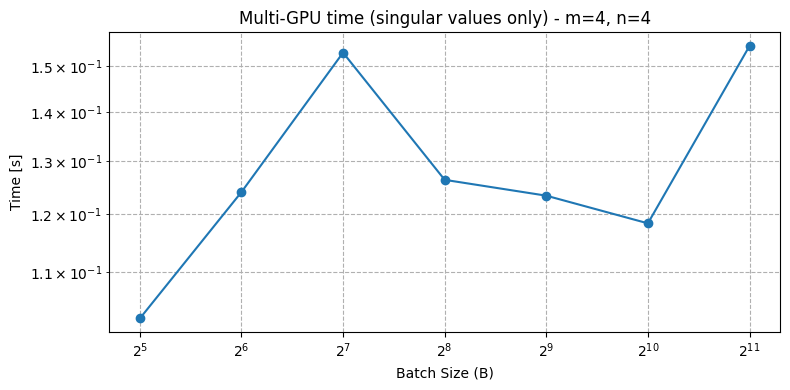

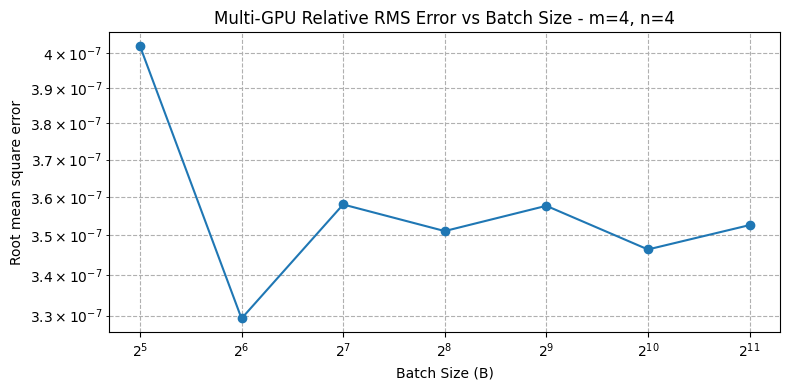

In [9]:
if __name__ == "__main__":
    # Matrix dimensions
    m, n = 4, 4
    batch_sizes = [32, 64, 128, 256, 512, 1024, 2048]

    # Warmup
    print("Warmup multi-GPU execution...")
    B0 = batch_sizes[0]
    if B0 % n_devices != 0:
        raise ValueError(f"Warmup batch size {B0} must be divisible by number of devices {n_devices}.")
    warmup_np = generate_random_batch(B0, m, n)
    warmup_jax = jnp.array(warmup_np, dtype=jax_dtype)
    warmup_shard = warmup_jax.reshape((n_devices, B0 // n_devices, m, n))
    S_warm = pmap_svals(warmup_shard)
    S_warm.block_until_ready()

    elapsed_times = []
    avg_errors = []

    for B in batch_sizes:
        if B % n_devices != 0:
            print(f"Skipping B={B}: not divisible by {n_devices} devices.")
            continue

        batch_np = generate_random_batch(B, m, n)
        batch_jax = jnp.array(batch_np, dtype=jax_dtype)
        batch_shard = batch_jax.reshape((n_devices, B // n_devices, m, n))

        # Timing multi-GPU pmap
        start = time.time()
        S_sharded = pmap_svals(batch_shard)
        S_sharded.block_until_ready()
        elapsed = time.time() - start
        elapsed_times.append(elapsed)

        # Gather and flatten
        S_j = np.array(S_sharded).reshape((B, min(m, n)))

        # Reference via NumPy
        S_ref = np.linalg.svd(batch_np.reshape(-1, m, n), compute_uv=False)
        if isinstance(S_ref, tuple):
            S_ref = S_ref[1]

        # Compute error
        rel_errors = np.linalg.norm(S_j - S_ref, axis=1) / np.linalg.norm(S_ref, axis=1)
        avg_err = np.mean(rel_errors)
        avg_errors.append(avg_err)

        print(f"B={B:5d} | time={elapsed:.6f}s | avg_rel_error={avg_err:.3e}")

    # Save results
    filename = "results_svals_jax_multi.csv"
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["batch_size", "elapsed_time", "avg_rel_error"])
        for B, t, e in zip([b for b in batch_sizes if b % n_devices == 0], elapsed_times, avg_errors):
            writer.writerow([B, t, e])
    print(f"Results saved in {filename}")

    # Plot results
    B_arr = np.array([b for b in batch_sizes if b % n_devices == 0])
    t_arr = np.array(elapsed_times)
    e_arr = np.array(avg_errors)

    plt.figure(figsize=(8, 4))
    plt.plot(B_arr, t_arr, marker='o')
    plt.title(f"Multi-GPU time (singular values only) - m={m}, n={n}")
    plt.xlabel("Batch Size (B)")
    plt.ylabel("Time [s]")
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.grid(True, which='both', ls='--')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(B_arr, e_arr, marker='o')
    plt.title(f"Multi-GPU Relative RMS Error vs Batch Size - m={m}, n={n}")
    plt.xlabel("Batch Size (B)")
    plt.ylabel("Root mean square error")
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.grid(True, which='both', ls='--')
    plt.tight_layout()
    plt.show()

